Se importan los paquetes a utilizar

In [21]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline 
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import missingno

Se carga el dataset

In [2]:
data= pd.read_csv('transaction_dataset.csv')
data

,Unnamed: 0,Index,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,1,0x00009277775ac7d0d59eaad8fee3d10ac6c805e8,0,844.26,1093.71,704785.63,721,89,0,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,2,0x0002b44ddb1476db43c868bd494422ee4c136fed,0,12709.07,2958.44,1218216.73,94,8,0,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,3,0x0002bda54cb772d040f779e88eb453cac0daa244,0,246194.54,2434.02,516729.30,2,10,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,4,0x00038e6ba2fd5c09aedb96697c8d7b8fa6632e5e,0,10219.60,15785.09,397555.90,25,9,0,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,5,0x00062d1dd1afb6fb02540ddad9cdebfe568e0d89,0,36.61,10707.77,382472.42,4598,20,1,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,9836,2175,0xff481ca14e6c16b79fc8ab299b4d2387ec8ecdd2,1,12635.10,631.39,58748.48,4,13,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork
9837,9837,2176,0xff718805bb9199ebf024ab6acd333e603ad77c85,1,0.00,0.00,0.00,0,0,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
9838,9838,2177,0xff8e6af02d41a576a0c82f7835535193e1a6bccc,1,2499.44,2189.29,261601.88,67,43,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com
9839,9839,2178,0xffde23396d57e10abf58bd929bb1e856c7718218,1,0.00,0.00,0.00,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


La columna Index no aporta información relevante para la detección de fraudes ya que simplemente es una columna para ordenar las transacciones. Para el entrenamiento del programa dicha columna se puede eliminar.

In [3]:
#Se eliminan las columnas Unnamed e Index
data.drop(columns=['Index'], inplace=True)

**Análisis de las variables categóricas**

In [ ]:
#Se imprimen las columnas con variables categóricas
data.describe(include='object').T

,count,unique,top,freq
Address,9841,9816,0x4c5b0709f66719861e7277c9dcda9175deb3d866,2
ERC20 most sent token type,9000,305,0,4399
ERC20_most_rec_token_type,8990,467,0,4399


In [ ]:
#Se ve qué tipo de datos hay en cada una de las columnas anteriores y cuál es la frecuencia con la que se repiten
for column in data.select_dtypes(include='object').columns:
    print(data[column].value_counts())
    print('-'*20)

0x4c5b0709f66719861e7277c9dcda9175deb3d866    2
0x4c13f6966dc24c92489344f0fd6f0e61f3489b84    2
0x4c26a3c12a64f33a3546fbb206c5365ce8e82c20    2
0x4cb981a7a2956cdfa8afbf454cb4e1b13c69aeb9    2
0x4cd526aa2db72eb1fd557b37c6b0394acd35b212    2
                                             ..
0x6cf481c7090d88ca6f1fa3c9ffd0911ef5359808    1
0x611fbaf58b3bf604745ba1f45ebba069d4331fd8    1
0x08fd8cde5d342463f7687faf908181841c7587c3    1
0x3447bf18a51f41bbb20aad8b96259e36a80e4874    1
0x1d18273e0246dc118384cecddb6eb10e61778343    1
Name: Address, Length: 9816, dtype: int64
--------------------
0                          4399
None                       1856
                           1191
EOS                         138
OmiseGO                     137
                           ... 
TrueFlip                      1
Synthetix Network Token       1
Electronic Energy Coin        1
Poker Chips                   1
Monolith TKN                  1
Name:  ERC20 most sent token type, Length: 305, dtype: in

Como se puede observar, la mayoría de datos de la columna Address son únicos, menos algunos que se repiten como mucho dos veces. Por ello se va a realizar un análisis de los datos no únicos de dicha columna para observar si es un campo relevante para la detección de fraudes. 

In [ ]:
# ¿Cuantas direcicones no son únicas?
_, uniq_idx, counts = np.unique(data['Address'].to_numpy(), return_index=True, return_counts=True)
non_unique_addresses_idx = uniq_idx[counts > 1]
print("non-unique adresses count: {}".format(len(non_unique_addresses_idx), end='\n\n'))

# ¿Cuál es el flag de esas direcicones?
non_unique_addresses_flags = data.iloc[non_unique_addresses_idx]['FLAG']
print("flags of non-unique adresses: ", end='')
print(*non_unique_addresses_flags)

non-unique adresses count: 25
flags of non-unique adresses: 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0


Como se puede observar en la salida del código anterior, solo hay 25 datos no únicos en la columna Address. Además, todos los datos repetidos pertenecen a transacciones no fraudulentas con lo que este campo no aporta información relevante y se puede eliminar. 


In [4]:
#Se eliminan las columnas con información irrelevante
data.drop(columns=['Address'])

,Unnamed: 0,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,Unique Sent To Addresses,...,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 min val sent contract,ERC20 max val sent contract,ERC20 avg val sent contract,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,0,844.26,1093.71,704785.63,721,89,0,40,118,...,0.000000,1.683100e+07,271779.920000,0.0,0.0,0.0,39.0,57.0,Cofoundit,Numeraire
1,1,0,12709.07,2958.44,1218216.73,94,8,0,5,14,...,2.260809,2.260809e+00,2.260809,0.0,0.0,0.0,1.0,7.0,Livepeer Token,Livepeer Token
2,2,0,246194.54,2434.02,516729.30,2,10,0,10,2,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,8.0,None,XENON
3,3,0,10219.60,15785.09,397555.90,25,9,0,7,13,...,100.000000,9.029231e+03,3804.076893,0.0,0.0,0.0,1.0,11.0,Raiden,XENON
4,4,0,36.61,10707.77,382472.42,4598,20,1,7,19,...,0.000000,4.500000e+04,13726.659220,0.0,0.0,0.0,6.0,27.0,StatusNetwork,EOS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9836,9836,1,12635.10,631.39,58748.48,4,13,0,11,4,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,2.0,,GSENetwork
9837,9837,1,0.00,0.00,0.00,0,0,0,0,0,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,1.0,,Blockwell say NOTSAFU
9838,9838,1,2499.44,2189.29,261601.88,67,43,0,31,44,...,0.000000,0.000000e+00,0.000000,0.0,0.0,0.0,0.0,5.0,,Free BOB Tokens - BobsRepair.com
9839,9839,1,0.00,0.00,0.00,0,1,0,1,0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Análisis de columnas numéricas**

Lo primero que se realiza es una descripción de los datos numéricos de cada columna, mostrando el número total de datos por columna, la media, la mediana, el máximo, el mínimo y los cuartiles. 

In [ ]:
# De las variables numéricas hallar datos estadísticos: máximo, mínimo, media, mediana y cuartiles
stats_df = data.describe()
# Obtener y añadir la mediana
median = pd.DataFrame(data.median())
median = median.transpose()
median.rename(index = {0:'median'},inplace = True)
stats_df = stats_df.append(median).transpose() # Hay q igualarlo porq append() devuelve nuevo df
stats_df

,count,mean,std,min,25%,50%,75%,max,median
Unnamed: 0,9841.0,4.920000e+03,2.840996e+03,0.00,2460.000000,4.920000e+03,7380.000000,9.840000e+03,4.920000e+03
FLAG,9841.0,2.214206e-01,4.152241e-01,0.00,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000e+00
Avg min between sent tnx,9841.0,5.086879e+03,2.148655e+04,0.00,0.000000,1.734000e+01,565.470000,4.302877e+05,1.734000e+01
Avg min between received tnx,9841.0,8.004851e+03,2.308171e+04,0.00,0.000000,5.097700e+02,5480.390000,4.821755e+05,5.097700e+02
Time Diff between first and last (Mins),9841.0,2.183333e+05,3.229379e+05,0.00,316.930000,4.663703e+04,304070.980000,1.954861e+06,4.663703e+04
Sent tnx,9841.0,1.159317e+02,7.572264e+02,0.00,1.000000,3.000000e+00,11.000000,1.000000e+04,3.000000e+00
Received Tnx,9841.0,1.637009e+02,9.408366e+02,0.00,1.000000,4.000000e+00,27.000000,1.000000e+04,4.000000e+00
Number of Created Contracts,9841.0,3.729702e+00,1.414456e+02,0.00,0.000000,0.000000e+00,0.000000,9.995000e+03,0.000000e+00
Unique Received From Addresses,9841.0,3.036094e+01,2.986211e+02,0.00,1.000000,2.000000e+00,5.000000,9.999000e+03,2.000000e+00
Unique Sent To Addresses,9841.0,2.584016e+01,2.638204e+02,0.00,1.000000,2.000000e+00,3.000000,9.287000e+03,2.000000e+00


Como se puede observar de la salida anterior, existen algunas columnas cuyos valores son todos nulos. Por ello, dichas columnas se pueden eliminar ya que no son relevantes para el modelo. 

In [5]:
#Se eliminan las columnas que solo tienen ceros:
data.drop(columns=[' ERC20 avg time between rec tnx', ' ERC20 avg time between rec 2 tnx', ' ERC20 avg time between contract tnx',
                 ' ERC20 min val sent contract', ' ERC20 max val sent contract', ' ERC20 avg val sent contract', ' ERC20 avg time between sent tnx'], inplace=True)

A continuación se procede a realizar la matriz de correlaciones entres los diferentes campos del dataset. Las correlaciones que son interesantes son las de la columna FLAG, ya que dicha columna es la variable de salida del modelo (indica si una transacción es normal (0) o fraudulenta (1))

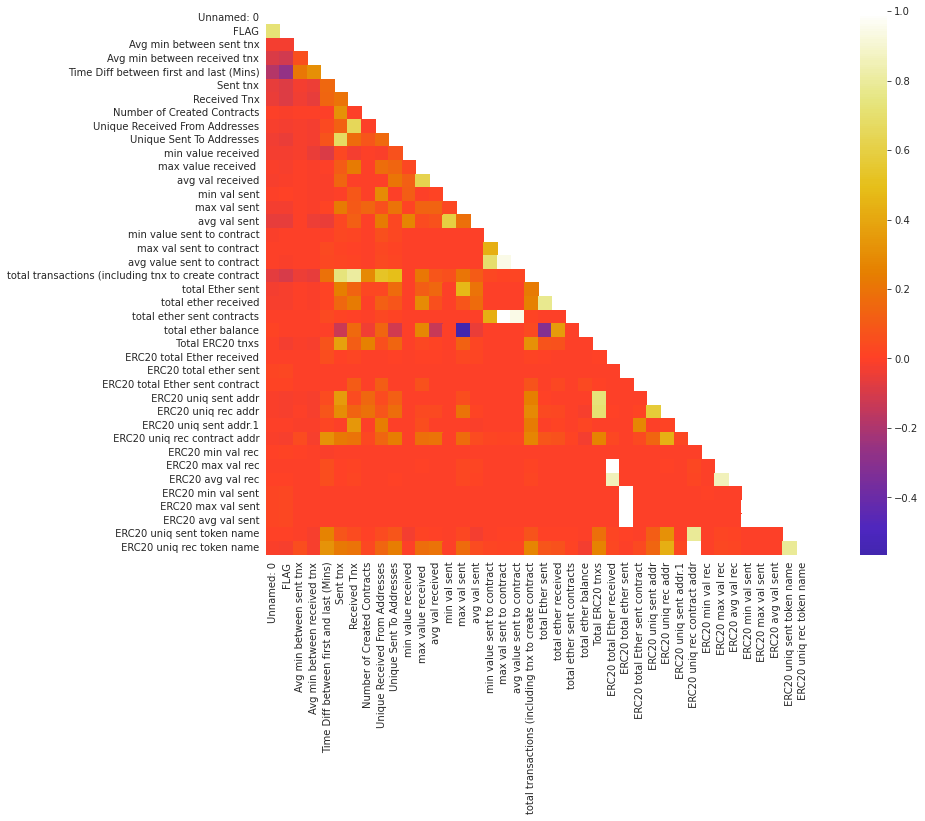

In [ ]:
# Matriz de Correlación
corr = data.corr()

mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)]=True
with sns.axes_style('white'):
    fig, ax = plt.subplots(figsize=(18,10))
    sns.heatmap(corr,  mask=mask, annot=False, cmap='CMRmap', center=0, square=True)

In [ ]:
#Encontrar las correlaciones más altas,
print('\033[1m'+'Listado de las variables con mayor influencia en el tipo de transacción junto a su coeficiente de correlación:'+'\033[0m')
important_var_list = []
for i in range(0,len(corr)):
    if corr['FLAG'][i] > 0.02:
        print('{} {}'.format(corr.index[i],corr.loc[corr.index[i],'FLAG']))
        important_var_list.append(corr.index[i])

Listado de las variables con mayor influencia en el tipo de transacción junto a su coeficiente de correlación:
Unnamed: 0 0.7191526526851808
FLAG 1.0
 ERC20 total ether sent 0.024762246540286807
 ERC20 min val sent 0.025364154087447317
 ERC20 max val sent 0.025038127044247467
 ERC20 avg val sent 0.02504351016185636


In [ ]:
#Se guarda la matriz de correlación en un csv
corr.to_csv('matriz_correlacion.csv')

 **Label Encoder y Tratamiento de Missing** 

Primero se realzia un análisis de los datos faltantes de forma previa a la aplicación del laber enconder. 

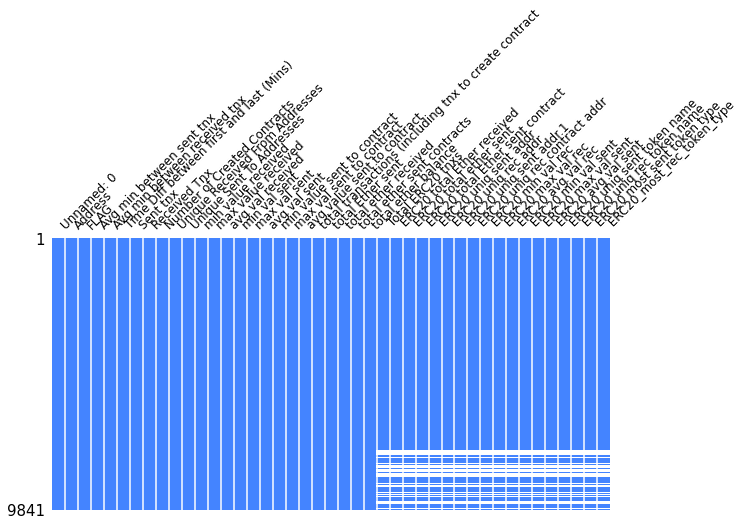

In [ ]:
missingno.matrix(data,sparkline=False, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0));

A continuación se observa las filas en las que hay datos faltantes.

In [ ]:
# Lista con los missing de cada columna
missing = data.isna().sum()
# Creamos dataframe con columnas y missing values
missing_df = pd.DataFrame([data.columns,missing]).transpose()
# Nos quedamos solo con  las columnas que tengan missing
for index in missing_df.index:
    if missing_df.iloc[index,1] > 0:
        print('Columna: {}, N of NaN: {}, Index in Dataframe: {}'.format(missing_df.iloc[index,0],missing_df.iloc[
            index,1],index))

Columna:  Total ERC20 tnxs, N of NaN: 829, Index in Dataframe: 25
Columna:  ERC20 total Ether received, N of NaN: 829, Index in Dataframe: 26
Columna:  ERC20 total ether sent, N of NaN: 829, Index in Dataframe: 27
Columna:  ERC20 total Ether sent contract, N of NaN: 829, Index in Dataframe: 28
Columna:  ERC20 uniq sent addr, N of NaN: 829, Index in Dataframe: 29
Columna:  ERC20 uniq rec addr, N of NaN: 829, Index in Dataframe: 30
Columna:  ERC20 uniq sent addr.1, N of NaN: 829, Index in Dataframe: 31
Columna:  ERC20 uniq rec contract addr, N of NaN: 829, Index in Dataframe: 32
Columna:  ERC20 min val rec, N of NaN: 829, Index in Dataframe: 33
Columna:  ERC20 max val rec, N of NaN: 829, Index in Dataframe: 34
Columna:  ERC20 avg val rec, N of NaN: 829, Index in Dataframe: 35
Columna:  ERC20 min val sent, N of NaN: 829, Index in Dataframe: 36
Columna:  ERC20 max val sent, N of NaN: 829, Index in Dataframe: 37
Columna:  ERC20 avg val sent, N of NaN: 829, Index in Dataframe: 38
Columna:  E

Por último se observa cuáles de esos datos pertenencen a transacciones fraudulentas

In [ ]:
non_fraud_rows, fraud_rows = np.where( [data.iloc[:,0]==1] )
print(data.iloc[fraud_rows,:].isna().sum()[-20:])

total ether sent contracts          0
total ether balance                 0
 Total ERC20 tnxs                   0
 ERC20 total Ether received         0
 ERC20 total ether sent             0
 ERC20 total Ether sent contract    0
 ERC20 uniq sent addr               0
 ERC20 uniq rec addr                0
 ERC20 uniq sent addr.1             0
 ERC20 uniq rec contract addr       0
 ERC20 min val rec                  0
 ERC20 max val rec                  0
 ERC20 avg val rec                  0
 ERC20 min val sent                 0
 ERC20 max val sent                 0
 ERC20 avg val sent                 0
 ERC20 uniq sent token name         0
 ERC20 uniq rec token name          0
 ERC20 most sent token type         0
 ERC20_most_rec_token_type          0
dtype: int64


Como se puede observar, la mayoría de los datos faltantes pertenecen a transacciones fraudulentas. 

A continuación se utiliza Label Encoder para pasar las variables categóricas a numéricas, ya que para el entrenamiento del modelo no puede haber columnas categóricas. 

In [6]:
#Se pasan las columnas categóricas a numéricas mediante Label Encoder
le = preprocessing.LabelEncoder()
data2 = data.apply(le.fit_transform)
data2.head()

,Unnamed: 0,Address,FLAG,Avg min between sent tnx,Avg min between received tnx,Time Diff between first and last (Mins),Sent tnx,Received Tnx,Number of Created Contracts,Unique Received From Addresses,...,ERC20 min val rec,ERC20 max val rec,ERC20 avg val rec,ERC20 min val sent,ERC20 max val sent,ERC20 avg val sent,ERC20 uniq sent token name,ERC20 uniq rec token name,ERC20 most sent token type,ERC20_most_rec_token_type
0,0,0,0,2697,1822,6744,412,89,0,40,...,0,2562,3242,0,1087,1237,39,57,63,300
1,1,1,0,4199,3024,7683,94,8,0,5,...,0,1360,1450,151,88,90,1,7,154,257
2,2,2,0,4998,2788,6255,2,10,0,10,...,0,1406,1484,0,0,0,0,8,185,436
3,3,3,0,4087,4991,5879,25,9,0,7,...,0,1916,2484,277,552,733,1,11,217,436
4,4,4,0,1329,4606,5809,581,20,1,7,...,0,2209,2749,0,726,944,6,27,238,154


Por último se observa si siguen faltando datos o se han rellenado con etiquetas del label enconder

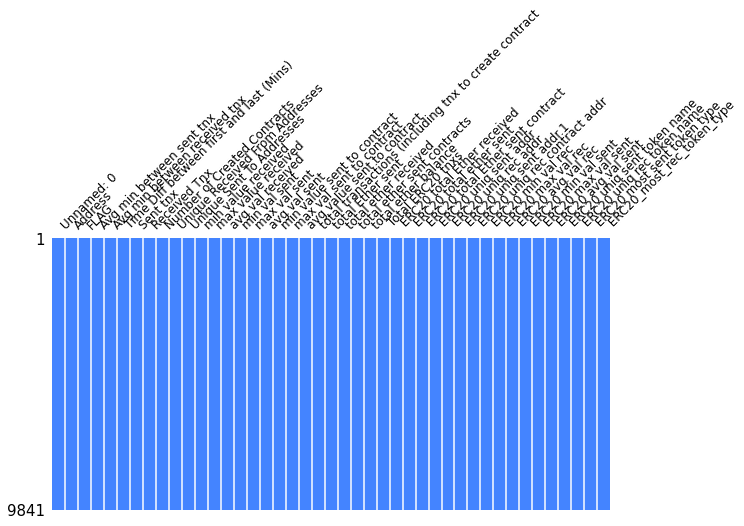

In [7]:
missingno.matrix(data2,sparkline=False, figsize=(10,5), fontsize=12, color=(0.27, 0.52, 1.0));

Como se puede observar, tras la aplicación de label encoder no hay datos faltantes

**Creación del modelo de detección de anomalías**

Lo primero que hacemos una exploración de las transacciones del dataset para ver qué porcentaje de ellas son fraudulentas y qué porcentaje son normales. 

In [ ]:
print(data2['FLAG'].value_counts())

0    7662
1    2179
Name: FLAG, dtype: int64


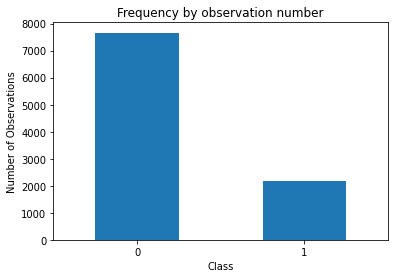

In [ ]:
count_classes = pd.value_counts(data2['FLAG'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

Como se puede observar es un dataset con datos desbalanceados (mayor número de transacciones normales que fraudulentas), aunque eso era de esperar ya que la clase anómala es siempre menor. 

El algoritmo a implementar va a ser Isolation Forest. Este modelo es como un árbol que va clasificando los datos en función de sus valores. Cuando se llega a la máxima profundidad en una de sus ramas, ese valor se cataloga como anómalo, ya que suelen ser los que menos características tienen en común con el resto de datos. 

Para poder entrenar el modelo se necesita separar los datos en dos conjuntos: Entrenamiento y test. 

In [7]:
train, test = train_test_split(data2, test_size=0.2)

In [8]:
cols = list(data2.columns[1:len(data2.columns)-1])

X_train = train[cols].values
Y_train=train['FLAG']

X_test = test[cols].values
Y_test=test['FLAG']

In [10]:
print(X_train.shape, Y_train.shape)
print(X_test.shape, Y_test.shape)

(7872, 41) (7872,)
(1969, 41) (1969,)


ver el porcentaje de transacciones fraudulentas en los datos de entrenamiento y de test

In [ ]:
print(train['FLAG'].value_counts())
print(test['FLAG'].value_counts())

0    6126
1    1746
Name: FLAG, dtype: int64
0    1536
1     433
Name: FLAG, dtype: int64


**Creación y entrenamiento del modelo**

In [10]:
#https://docs.ray.io/en/master/tune/index.html#:~:text=Tune%20is%20a%20Python%20library%20for%20experiment,execution%20and%20hyperparameter%20tuning%20at%20any%20scale.

#Aplicar algoritmo de optimización al modelo e imprimir el mejor modelo
from ray import tune

def objective(step, alpha, beta):
    return (0.1 + alpha * step / 100)**(-1) + beta * 0.1


def training_function(config):
    # Hyperparameters
    alpha, beta = config["alpha"], config["beta"]
    for step in range(10):
        # Iterative training function - can be any arbitrary training procedure.
        intermediate_score = objective(step, alpha, beta)
        # Feed the score back back to Tune.
        tune.report(mean_loss=intermediate_score)


analysis = tune.run(
    training_function,
    config={
        "alpha": tune.grid_search([0.001, 0.01, 0.1]),
        "beta": tune.choice([1, 2, 3])
    })

print("Best config: ", analysis.get_best_config(
    metric="mean_loss", mode="min"))

# Get a dataframe for analyzing trial results.
df = analysis.results_df

2021-12-19 18:11:35,067	WARNING function_runner.py:561 -- Function checkpointing is disabled. This may result in unexpected behavior when using checkpointing features or certain schedulers. To enable, set the train function arguments to be `func(config, checkpoint_dir=None)`.
2021-12-19 18:11:35,091	INFO logger.py:605 -- pip install "ray[tune]" to see TensorBoard files.
2021-12-19 18:11:35,099	WARNING callback.py:114 -- The TensorboardX logger cannot be instantiated because either TensorboardX or one of it's dependencies is not installed. Please make sure you have the latest version of TensorboardX installed: `pip install -U tensorboardx`


Trial name,status,loc,alpha,beta
training_function_b839c_00000,PENDING,,0.001,3
training_function_b839c_00001,PENDING,,0.01,3
training_function_b839c_00002,PENDING,,0.1,2


2021-12-19 18:11:35,429	ERROR syncer.py:111 -- Log sync requires rsync to be installed.


Result for training_function_b839c_00000:
  date: 2021-12-19_18-11-37
  done: false
  experiment_id: 35208f8eb3364f9791966ea3e03e0462
  hostname: DESKTOP-8RP5M1P
  iterations_since_restore: 1
  mean_loss: 10.3
  neg_mean_loss: -10.3
  node_ip: 127.0.0.1
  pid: 12188
  time_since_restore: 0.008001565933227539
  time_this_iter_s: 0.008001565933227539
  time_total_s: 0.008001565933227539
  timestamp: 1639933897
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b839c_00000
  
Result for training_function_b839c_00002:
  date: 2021-12-19_18-11-37
  done: false
  experiment_id: 7718ea3ff6b74b4ab5c65c9a1a142ac6
  hostname: DESKTOP-8RP5M1P
  iterations_since_restore: 1
  mean_loss: 10.2
  neg_mean_loss: -10.2
  node_ip: 127.0.0.1
  pid: 21140
  time_since_restore: 0.0
  time_this_iter_s: 0.0
  time_total_s: 0.0
  timestamp: 1639933897
  timesteps_since_restore: 0
  training_iteration: 1
  trial_id: b839c_00002
  
Result for training_function_b839c_00001:
  date: 2021-12-19_18-11-

Trial name,status,loc,alpha,beta,loss,iter,total time (s),neg_mean_loss
training_function_b839c_00000,TERMINATED,127.0.0.1:12188,0.001,3,10.291,10,0.0640152,-10.291
training_function_b839c_00001,TERMINATED,127.0.0.1:20860,0.01,3,10.2108,10,0.0880208,-10.2108
training_function_b839c_00002,TERMINATED,127.0.0.1:21140,0.1,2,9.37431,10,0.0640275,-9.37431


2021-12-19 18:11:37,559	INFO tune.py:626 -- Total run time: 2.50 seconds (2.24 seconds for the tuning loop).


Best config:  {'alpha': 0.1, 'beta': 2}


C:\Users\alici\anaconda3\lib\site-packages\ray\tune\analysis\experiment_analysis.py:262: UserWarning: Dataframes will use '/' instead of '.' to delimit nested result keys in future versions of Ray. For forward compatibility, set the environment variable TUNE_RESULT_DELIM='/'
  warnings.warn(


In [11]:
#Predecir clasificación con el conjunto de datos de test
svm_clf = svm.SVC(kernel='linear', C=0.1, gamma=2)

In [12]:
svm_clf.fit(X_train, Y_train)

SVC(C=0.1, gamma=2, kernel='linear')

In [13]:
y_pred = svm_clf.predict(X_test)

In [16]:
def calculate_metrics(real, predicted):
    print("Accuracy: {:.4f}".format(accuracy_score(real, predicted)))
    print("Precision: {:.4f}".format(precision_score(real, predicted,average = 'weighted')))
    # La sensibilidad es equivalente al recall
    print("Sensibilidad: {:.4f}".format(recall_score(real, predicted,average = 'weighted')))
    print("F1: {:.4f}".format(f1_score(real, predicted,average = 'weighted',labels=np.unique(predicted))))

In [17]:
calculate_metrics(Y_test, y_pred)

Accuracy: 0.9909
Precision: 0.9909
Sensibilidad: 0.9909
F1: 0.9908


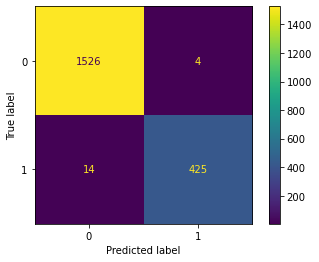

In [20]:
plot_confusion_matrix(svm_clf, X_test, Y_test)  
plt.show()